<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span><ul class="toc-item"><li><span><a href="#UPD2-Элементы-нового-вектора-весовых-коэффициентов-являются-линейными-комбинацими-старого-вектора-весов.-Так-как-присутствует-линейная-связь-каждого-элемента,-операция-не-должна-влиять-на-обучение." data-toc-modified-id="UPD2-Элементы-нового-вектора-весовых-коэффициентов-являются-линейными-комбинацими-старого-вектора-весов.-Так-как-присутствует-линейная-связь-каждого-элемента,-операция-не-должна-влиять-на-обучение.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>UPD2 Элементы нового вектора весовых коэффициентов являются линейными комбинацими старого вектора весов. Так как присутствует линейная связь каждого элемента, операция не должна влиять на обучение.</a></span></li></ul></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore");


from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error
import random

In [2]:
#Открываю файл и смотрю данные
data = pd.read_csv('/datasets/insurance.csv')
display(data)
print(data.info())

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None


В таблице 4 столбца признаков и один целевой - страховые выплаты, который содержит до 5 значений. Тут подойдет линейная регрессия для задачи классификации небинарного признака. Пропущенных значений нет.

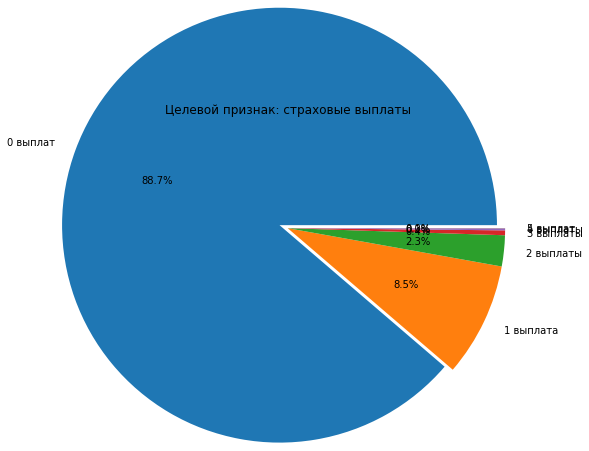

In [3]:
# Целевой признак
labels = ['0 выплат','1 выплата','2 выплаты','3 выплаты','4 выплаты','5 выплат']
compensation = data['Страховые выплаты'].value_counts()
explode = (0.1, 0, 0, 0, 0, 0)
plt.pie(compensation, autopct='%1.1f%%', radius=2.5, labels=labels,explode=explode );
plt.title('Целевой признак: страховые выплаты');
plt.show();

88.7% всех выплат равны 0.

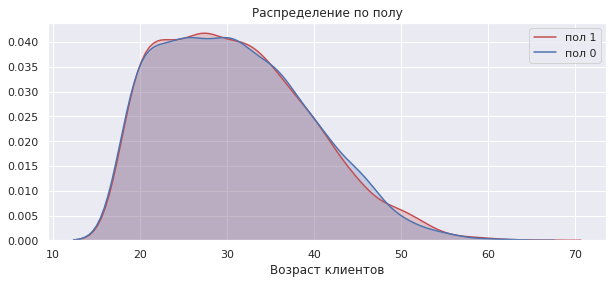

In [4]:
#Другой признак: Пол и возраст
sns.set(rc={'figure.figsize':(10,4)})
ax = sns.kdeplot(data[data['Пол']==1].Возраст , shade=True, color='r', label='пол 1')
ax = sns.kdeplot(data[data['Пол']==0].Возраст , shade=True, color='b', label='пол 0')
plt.title('Распределение по полу')
plt.xlabel('Возраст клиентов');

Очень близкие данные соотношения пола и возраста.

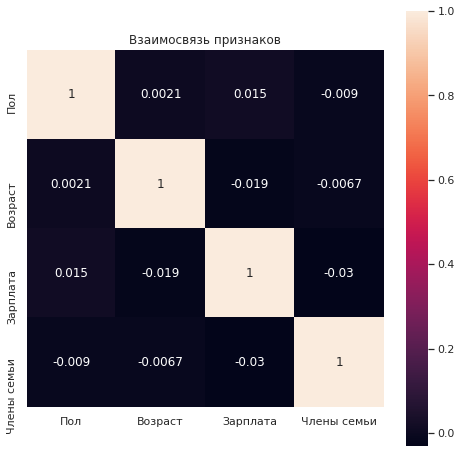

In [5]:
#Корреляция признаков
columns = ['Пол', 'Возраст', 'Зарплата', 'Члены семьи']
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data[columns].corr(), square=True, ax=ax, annot = True);
plt.title('Взаимосвязь признаков');

Корреляции признаков незначительны

## Умножение матриц

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Не изменится

**Обоснование:** умножим матрицу Х на Р получим матрицу ХР

$$
a = XPw
$$

где wp:

$$
wp = ((XP^T)XP)^{-1}(XP)^Ty
$$

$$
((XP)^TXP)^{-1}(XP)^T = (P^TX^T)^{-1}P^TX^T = P^{-1}(X^TX)^{-1}EX^T = P^{-1}(X^TX)^{-1}X^T
$$

$$
w = P^{-1}(X^TX)-1X^Ty = P^{-1}w
$$
Произведение матрицы на обратную дает единичную, получаем:

$$
a = XPP^{-1}w
$$

$$
a = Xw
$$

### UPD2 Элементы нового вектора весовых коэффициентов являются линейными комбинацими старого вектора весов. Так как присутствует линейная связь каждого элемента, операция не должна влиять на обучение.

## Алгоритм преобразования

**Алгоритм**
1.Создадим квадратную матрицу с помощью модуля numpy random размерностью признаков основной +1( 4 на 4)
2. Проверим на обратимость с помощью встроенной функции np.linalg.inv
3. Домножим справа матрицу признаков с присоединенным слева единичным столбцом Х на случайную матрицу Р
4. Обучим модель на новых данных и убедимся, что качество предсказаний осталось как и с исходными данными.

**Обоснование**

Исходя из проведенных теоретических рассчетов, качество предсказания модели не должно измениться. 

## Проверка алгоритма

In [6]:
#Разделим на обучающую и валидационную
data_train, data_valid = train_test_split(data, test_size=0.25, random_state=12345)

#Разделим признаки
features_train = data_train.drop(['Страховые выплаты'], axis=1)
target_train = data_train['Страховые выплаты']

features_valid = data_valid.drop(['Страховые выплаты'], axis=1)
target_valid = data_valid['Страховые выплаты']

print('Размер обучающей выборки:', data_train.shape[0],'объектов')
print('Размер валидационной выборки:', data_valid.shape[0],'объекта')

Размер обучающей выборки: 3750 объектов
Размер валидационной выборки: 1250 объекта


In [7]:
#модель до преобразования
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
predictions = model_1.predict(features_valid)
print('r2 row',r2_score(target_valid, predictions))

r2 row 0.435227571270266


In [8]:
#создадим квадратную матрицу размера 4-4 (так как признаков 4 столбца)
try:
    features_reversed = np.random.randint(0, 15, size=(4, 4))
    reverse = np.linalg.inv(features_reversed)
except:
    print('Матрица необратима')

#проверим на обратимость
#reverse = np.linalg.inv(features_reversed)

#перемножим изначальную матрицу на обратимую
new_features_train = features_train.dot(features_reversed)
print('=========Преобразованная матрица признаков===========')
display(new_features_train)

new_features_valid = features_valid.dot(features_reversed)

=========Преобразованная матрица признаков===========


,0,1,2,3
3369,36559.0,36765.0,398422.0,362583.0
1441,57885.0,58043.0,633775.0,576453.0
571,41358.0,41521.0,452262.0,411429.0
225,45390.0,45573.0,496282.0,451481.0
2558,50868.0,51039.0,556769.0,506455.0
...,...,...,...,...
3497,32436.0,32646.0,353310.0,321546.0
3492,22932.0,23084.0,249848.0,227416.0
2177,45043.0,45239.0,491912.0,447557.0
3557,50284.0,50406.0,551218.0,501338.0


Преобразованная матрица признаков изменилась до неузнаваемости.

In [9]:
#обучим модель после преобразования
model_2 = LinearRegression()
model_2.fit(new_features_train, target_train)
predictions_new = model_2.predict(new_features_valid)
r2_score(target_valid, predictions_new)

0.4352275712701791

Значение метрик r2 до и после домножения исходной матрицы признаков на обратимую матрицу остались практически без изменений, что и описывалось в алгоритме.